# <center><span style="color:RED"> ***MACHINE LEARNING. PREDICCIÓN FÓRMULA 1***</span></center>

- Clasificación final. PODIO
- Predecir y ordenar resultados de menor a mayor

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sqlite3
import os
import sys
import re
import seaborn as sns
import scipy.stats as ss
import random
import statsmodels.api as sm


import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")


In [2]:
os.getcwd()

'c:\\Users\\j\\Documents\\THEBRIDGE_2023\\streamlitF1\\notebooks'

In [3]:
sys.path.append(os.path.dirname(os.getcwd()))

In [4]:

# user functions
from src.user_func import validators_reg, validators_clf, comparador

In [5]:
# Ampliar tamaño columnas
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [6]:
# archivo original, sin lag de datos de carreras previas

f1_original=pd.read_csv(r'../csv/F1_ML_original.csv')
f1_original.drop('Unnamed: 0', axis=1, inplace=True) #quitar columna Unnamed: 0

In [7]:
# archivo con columnas con lag de carrera anterior

f1=pd.read_csv(r'../csv/F1_ML_con_prev.csv')
f1.drop('Unnamed: 0', axis=1, inplace=True) #quitar columna Unnamed: 0

In [8]:
f1.drop(columns=['position', 'points','total_race_time','fastestLap','pit_stop_mean_driver','pit_stop_mean_race','total_stops','pit_stop_total_time'], axis=1, inplace=True)
# quitar las columnas con valores actuales, dejando los valores lag de carreras previas, para poder predecir el valor de la ultima temporada

# dejamos grid (posición de salida), porque es justo anterior a la carrera, y está bien correlada con la posición final

In [9]:
f1.track.unique()

array(['Chinese GP', 'Turkish GP', 'Spanish GP', 'Monaco GP',
       'Canadian GP', 'European GP', 'British GP', 'German GP',
       'Hungarian GP', 'Belgian GP', 'Italian GP', 'Singapore GP',
       'Japanese GP', 'Korean GP', 'Indian GP', 'Abu Dhabi GP',
       'Brazilian GP', 'Australian GP', 'Malaysian GP', 'Bahrain GP',
       'United States GP', 'Austrian GP', 'Russian GP', 'Mexican GP',
       'Azerbaijan GP', 'French GP', 'Styrian GP', '70th Anniversary GP',
       'Tuscan GP', 'Eifel GP', 'Portuguese GP', 'Emilia Romagna GP',
       'Sakhir GP', 'Qatar GP', 'Dutch GP', 'Mexico City GP',
       'São Paulo GP', 'Saudi Arabian GP', 'Miami GP'], dtype=object)

### CORRELACIÓN DE DATOS

In [10]:
# Función que devuelve lista con parejas de variables con correlación superior o inferior a 0.5
# de un dataframe de correlacion pasado como argumento

def mas_correladas(crr):
    lista_corr=[]
    # rango i tamaño de índice -1
    #   rango j tamaño de columnas

    for i in range(0,len(crr.index)-1):
        for j in range(i+1, len(crr.columns)):
            # print(corr_races.iloc[i,j])
            # print(corr_races.index[i])
            # print(corr_races.columns[j])
        # si el valor en la posición i,j cumple requisitos
        
            if (crr.iloc[i,j]!=1) & ((crr.iloc[i,j]>0.5) | (crr.iloc[i,j]<-0.5)):

                # pasamos a lista nombre de la fila, nombre de la columna y el valor de la correlación
                lista_corr.append([crr.index[i], crr.columns[j],crr.iloc[i,j]])
    print('\nMás correladas:')
    return lista_corr

<Axes: >

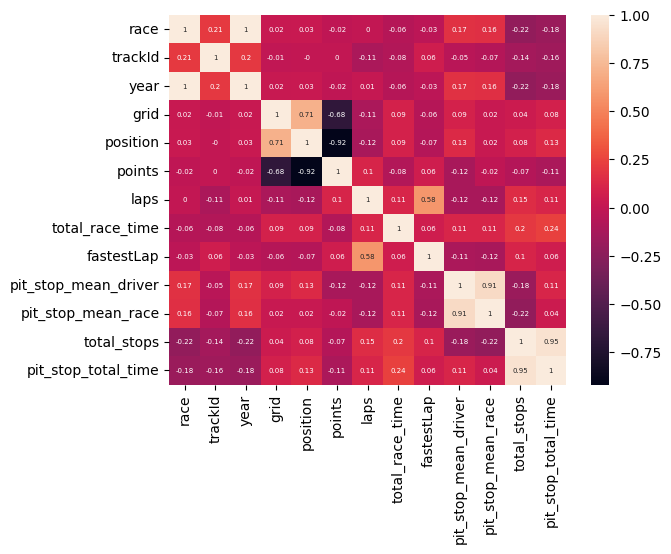

In [11]:
sns.heatmap(f1_original.select_dtypes('number').corr(method='pearson').round(2), annot=True, annot_kws={"size":5})

In [12]:
corr=f1.select_dtypes('number').corr(method='pearson').round(2)

In [13]:
mas_correladas(corr.corr(method='pearson'))


Más correladas:


[['race', 'year', 0.9999472603537869],
 ['race', 'prev_position', -0.551957024349563],
 ['race', 'prev_pit_mean_drv', -0.5887366435783119],
 ['race', 'prev_pit_mean_race', -0.5924012310652126],
 ['race', 'prev_total_stops', -0.6719993776951725],
 ['race', 'prev_total_race_time', -0.5993909087703501],
 ['race', 'prev_pit_total_time', -0.6623694644909666],
 ['race', 'prev_fast_lap', -0.6111571722932994],
 ['year', 'prev_position', -0.5532831801684437],
 ['year', 'prev_pit_mean_drv', -0.5896806583256096],
 ['year', 'prev_pit_mean_race', -0.5933458763296399],
 ['year', 'prev_total_stops', -0.6727162184075747],
 ['year', 'prev_total_race_time', -0.60007389332627],
 ['year', 'prev_pit_total_time', -0.6631650150657542],
 ['year', 'prev_fast_lap', -0.6119424756636691],
 ['grid', 'prev_points', -0.8608031565614872],
 ['grid', 'prev_pit_mean_drv', -0.7309336083319217],
 ['grid', 'prev_pit_mean_race', -0.7360337959189805],
 ['grid', 'prev_total_stops', -0.6588342077840541],
 ['grid', 'prev_total_

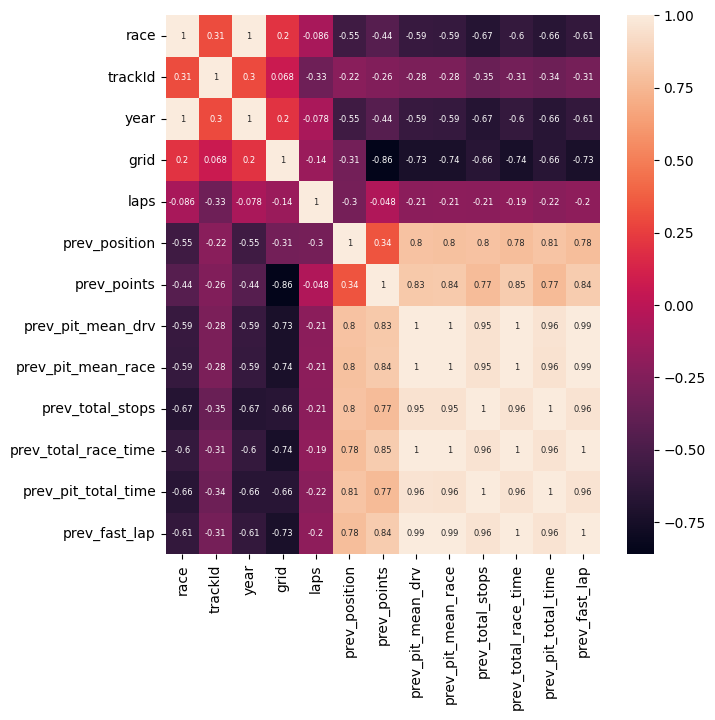

In [14]:
# mapa
plt.figure(figsize=(7,7))
sns.heatmap(corr.corr(method='pearson'), annot=True, annot_kws={"size":6})
plt.show();

In [15]:
f1.select_dtypes('number').skew()

# No se asemejan a la normal

race                    0.019066
trackId                 1.227244
year                    0.013624
grid                    0.620425
laps                    0.268460
prev_position           1.166827
prev_points             0.949961
prev_pit_mean_drv      -0.287568
prev_pit_mean_race     -0.319174
prev_total_stops        0.741535
prev_total_race_time   -0.252992
prev_pit_total_time     0.699171
prev_fast_lap          -0.073282
dtype: float64

In [16]:
f1.select_dtypes('number').kurtosis()

race                   -1.318777
trackId                -0.032470
year                   -1.333569
grid                   -0.544444
laps                    0.330544
prev_position           0.616248
prev_points            -0.310064
prev_pit_mean_drv      -1.704036
prev_pit_mean_race     -1.733930
prev_total_stops       -0.086352
prev_total_race_time   -1.709373
prev_pit_total_time    -0.139133
prev_fast_lap          -1.631261
dtype: float64

### SELECCIÓN DATOS/ESTADÍSTICAS, GRÁFICOS

In [17]:
# ganador de cada carrera

# f1[['year','race','driver','position']][f1.position==1]

In [18]:
# SUMA DE VECES QUE HA QUEDADO CADA PILOTO EN UNA POSICIÓN EN 2022 y 2023

piv01=f1_original[f1_original.year.isin([2022,2023])].pivot_table(
    index='driver', 
    columns=['year', 'position'], 
    values='total_race_time', 
    #margins=True,
    aggfunc='count',
    fill_value='--'
    )
piv01


year            2022                                                          \
position          1   2   3   4   5   6   7   8   9   10  11  12  13  14  15   
driver                                                                         
albon             --  --  --  --  --  --  --  --   1   2  --   1   4  --   1   
alonso            --  --  --  --   3   2   4  --   2  --   1  --  --  --  --   
bottas            --  --  --  --  --   2   2   1   2  --   1  --  --   1   1   
de_vries          --  --  --  --  --  --  --  --   1  --  --  --  --  --  --   
gasly             --  --  --  --   1  --  --   2   2   1   2   1  --   3  --   
hamilton          --   5   4   3   3   1  --   1  --   1  --  --  --  --  --   
hulkenberg        --  --  --  --  --  --  --  --  --  --  --   1  --  --  --   
kevin_magnussen   --  --  --  --   1  --  --  --   3   1  --   1  --   1   1   
latifi            --  --  --  --  --  --  --  --   1  --  --   1  --   1  --   
lawson            --  --  --  --  --  --  --  --  --  --  --  --  --  --  --   
leclerc            3   5   3   3   1   4  --  --  --  --  --  --  --  --  --   
max_verstappen    15   1   1  --  --   1   2  --  --  --  --  --  --  --  --   
mick_schumacher   --  --  --  --  --  --  --   1  --  --   1   1   2  --   3   
norris            --  --   1   1   1   4   5   1   1   1  --   1  --  --   2   
ocon              --  --  --   1   1   2   5   2   1   1   2   1  --  --  --   
perez              2   7   2   3   2   1   1  --  --  --  --  --  --  --  --   
piastri           --  --  --  --  --  --  --  --  --  --  --  --  --  --  --   
ricciardo         --  --  --  --   1   1  --   1   2  --   2  --   3   1   1   
russell            1   1   5   6   5  --  --   1  --  --  --  --  --  --  --   
sainz              1   3   5   4   1  --  --   1  --  --  --  --  --  --  --   
sargeant          --  --  --  --  --  --  --  --  --  --  --  --  --  --  --   
stroll            --  --  --  --  --   1  --   1  --   4   2   3  --   1  --   
tsunoda           --  --  --  --  --  --   1   1  --   1   1   1   2   1  --   
vettel            --  --  --  --  --   2  --   4   1   2   2   1  --   1  --   
zhou              --  --  --  --  --  --  --   1  --   2   2   2  --   1  --   

year                        2023                                              \
position         16  17  18   1   2   3   4   5   6   7   8   9   10  11  12   
driver                                                                         
albon            --  --  --   --  --  --  --  --  --   2   2  --   1   2   1   
alonso           --  --  --   --   3   3   1   2   1   2   1   2  --  --  --   
bottas           --  --  --   --  --  --  --  --  --  --   2  --   2   1   2   
de_vries         --  --  --   --  --  --  --  --  --  --  --  --  --  --  --   
gasly            --  --   1   --  --   1  --  --   1   1   1   2   3   1   2   
hamilton         --  --  --   --   1   3   3   3   4  --   1  --  --  --  --   
hulkenberg       --   1  --   --  --  --  --  --  --  --  --  --  --  --   2   
kevin_magnussen  --  --  --   --  --  --  --  --  --  --  --  --   3  --  --   
latifi            3   1  --   --  --  --  --  --  --  --  --  --  --  --  --   
lawson           --  --  --   --  --  --  --  --  --  --  --   1  --   1  --   
leclerc          --  --  --   --   1   2   4   1   1   3  --   1  --   1  --   
max_verstappen   --  --  --   13   2  --  --   1  --  --  --  --  --  --  --   
mick_schumacher  --   1  --   --  --  --  --  --  --  --  --  --  --  --  --   
norris           --  --  --   --   4   1   1  --  --   2   1   1  --  --  --   
ocon             --  --  --   --  --   1  --  --  --   1   4   2   1  --  --   
perez            --  --  --    2   4   2   2   1   2  --   1  --   1  --  --   
piastri          --  --  --   --   1   1   1   1  --   1   1   1  --   2   1   
ricciardo         1   1  --   --  --  --  --  --  --  --  --  --  --  --  --   
russell          --  --  --   --  --   1   3   3   2   3   1  --  --  --  --   

In [19]:
### TIEMPO MEDIO POR CARRERA Y POR PILOTO

# -- significa que el piloto no corrió esa carrera o no la terminó

f1_original[(f1_original.year.between(2019,2023))&((f1_original.driver=='alonso') | (f1_original.driver=='hamilton') | (f1_original.driver=='max_verstappen'))].round(2).pivot_table(\
    index=('year', 'driver'), 
    columns=('track'), 
    values=('total_race_time'), 
    fill_value="--")

track               70th Anniversary GP Abu Dhabi GP Australian GP  \
year driver                                                          
2019 hamilton                        --    5645715.0     5148211.0   
     max_verstappen                  --    5662487.0     5149845.0   
2020 hamilton                 4793319.0    5807060.0            --   
     max_verstappen           4781993.0    5788645.0            --   
2021 alonso                          --    5479053.0            --   
     hamilton                        --    5419601.0            --   
     max_verstappen                  --    5417345.0            --   
2022 alonso                          --           --            --   
     hamilton                        --           --     5295091.0   
     max_verstappen                  --    5265914.0            --   
2023 alonso                          --           --            --   
     hamilton                        --           --            --   
     max_verstappen                  --           --            --   

track               Austrian GP Azerbaijan GP  Bahrain GP Belgian GP  \
year driver                                                            
2019 hamilton         4944627.0     5514466.0   5661295.0  5026691.0   
     max_verstappen   4921822.0     5530435.0   5667703.0         --   
2020 hamilton         5461428.0            --  10787515.0  5048761.0   
     max_verstappen          --            --  10788769.0  5064216.0   
2021 alonso                  --     8022792.0          --         --   
     hamilton         5080995.0     8034078.0   5523897.0         --   
     max_verstappen   5034543.0            --   5524642.0         --   
2022 alonso                  --     5734537.0   5875974.0  5226150.0   
     hamilton         5105529.0     5717620.0   5863259.0         --   
     max_verstappen   5065844.0     5645941.0          --  5152894.0   
2023 alonso           5163924.0     5584460.0   5675373.0  5006634.0   
     hamilton         5182803.0     5608581.0   5687713.0  5000121.0   
     max_verstappen   5133607.0     5564573.0   5636736.0  4950450.0   

track               Brazilian GP British GP Canadian GP Chinese GP   Dutch GP  \
year driver                                                                     
2019 hamilton          5605817.0  4868452.0   5347084.0  5526350.0         --   
     max_verstappen    5594678.0  4907910.0   5404739.0  5553977.0         --   
2020 hamilton                 --  5281283.0          --         --         --   
     max_verstappen           --  5287139.0          --         --         --   
2021 alonso                   --  7175377.0          --         --         --   
     hamilton                 --         --          --         --  5426327.0   
     max_verstappen           --         --          --         --  5405395.0   
2022 alonso                   --  8279882.0   5811702.0         --  5821527.0   
     hamilton                 --  8276536.0   5788763.0         --  5815789.0   
     max_verstappen           --  8289088.0   5781757.0         --  5802773.0   
2023 alonso                   --  5134131.0   5647918.0         --  8648155.0   
     hamilton                 --  5123721.0   5642946.0         --  8657620.0   
     max_verstappen           --  5116938.0   5638348.0         --  8644411.0   

track                 Eifel GP Emilia Romagna GP  French GP  German GP  \
year driver                                                              
2019 hamilton               --                --  5071198.0  6290942.0   
     max_verstappen         --                --  5106103.0  6271275.0   
2020 hamilton        5749641.0         5312430.0         --         --   
     max_verstappen  5754111.0                --         --         --   
2021 alonso                 --         7421159.0  5323465.0         --   
     hamilton               --         7376598.0  5248674.0         --   
     max_verstappen         --         7354598.0  5245770.0 

In [20]:
# MEDIA TIEMPO DE CARRERA
pivot21_23=f1_original[(f1_original.year.between(2019,2023))&((f1_original.driver=='alonso') | (f1_original.driver=='hamilton') | (f1_original.driver=='max_verstappen'))].round(2).pivot_table(index=('year', 'driver'), columns=('track'), values=('total_race_time'), fill_value='--')
pivot21_23.T

year                      2019                       2020                 \
driver                hamilton max_verstappen    hamilton max_verstappen   
track                                                                      
70th Anniversary GP         --             --   4793319.0      4781993.0   
Abu Dhabi GP         5645715.0      5662487.0   5807060.0      5788645.0   
Australian GP        5148211.0      5149845.0          --             --   
Austrian GP          4944627.0      4921822.0   5461428.0             --   
Azerbaijan GP        5514466.0      5530435.0          --             --   
Bahrain GP           5661295.0      5667703.0  10787515.0     10788769.0   
Belgian GP           5026691.0             --   5048761.0      5064216.0   
Brazilian GP         5605817.0      5594678.0          --             --   
British GP           4868452.0      4907910.0   5281283.0      5287139.0   
Canadian GP          5347084.0      5404739.0          --             --   
Chinese GP           5526350.0      5553977.0          --             --   
Dutch GP                    --             --          --             --   
Eifel GP                    --             --   5749641.0      5754111.0   
Emilia Romagna GP           --             --   5312430.0             --   
French GP            5071198.0      5106103.0          --             --   
German GP            6290942.0      6271275.0          --             --   
Hungarian GP         5703796.0      5721592.0   5772473.0      5781175.0   
Italian GP           4561864.0      4601157.0   6443301.0             --   
Japanese GP          4920613.0             --          --             --   
Mexican GP           5808904.0      5877711.0          --             --   
Mexico City GP              --             --          --             --   
Miami GP                    --             --          --             --   
Monaco GP            6208437.0      6213974.0          --             --   
Portuguese GP               --             --   5396828.0      5431336.0   
Qatar GP                    --             --          --             --   
Russian GP           5618992.0      5633202.0          --      5648093.0   
Saudi Arabian GP            --             --          --             --   
Singapore GP         7118275.0      7117488.0          --             --   
Spanish GP           5750443.0      5758122.0   5505279.0      5529456.0   
Styrian GP                  --             --   4970683.0      5004381.0   
São Paulo GP                --             --          --             --   
Turkish GP                  --             --   6139313.0      6184186.0   
Tuscan GP                   --             --   8375060.0             --   
United States GP     5639801.0      5640655.0          --             --   

year                      2021                                  2022  \
driver                  alonso   hamilton max_verstappen      alonso   
track                                                                  
70th Anniversary GP         --         --             --          --   
Abu Dhabi GP         5479053.0  5419601.0      5417345.0          --   
Australian GP               --         --             --          --   
Austrian GP                 --  5080995.0      5034543.0          --   
Azerbaijan GP        8022792.0  8034078.0             --   5734537.0   
Bahrain GP                  --  5523897.0      5524642.0   5875974.0   
Belgian GP                  --         --             --   5226150.0   
Brazilian GP                --         --             --          --   
British GP           7175377.0         --             --   8279882.0   
Canadian GP                 --         --             --   5811702.0   
Chinese GP                  --         --             --          --   
Dutch GP                    --  5426327.0      5405395.0   5821527.0   
Eifel GP                    --         --             --          --   
Emilia Romagna GP    7421159.0  737

In [21]:
# equipo carrera,año, posicion final
f1_original[['team', 'trackId','track','year','driver', 'total_race_time','grid', 'position']].sort_values(['year', 'track', 'position'], ascending=True).sample(4)


,team,trackId,track,year,driver,total_race_time,grid,position
497,toro_rosso,6,Monaco GP,2013,vergne,8299279,10,8
1592,renault,24,Abu Dhabi GP,2018,sainz,6052930,11,6
104,mclaren,22,Japanese GP,2011,button,5453427,2,1
893,red_bull,17,Chinese GP,2015,ricciardo,6014125,7,9


In [22]:
# media de tiempos de carrera
f1_original.groupby(['team', 'track']).agg({'total_race_time':'mean', 'race':'count'}).sort_values(['total_race_time']).sample(4)

,,total_race_time,race
team,track,,
mercedes,Monaco GP,6.711346e+06,20
racing_point,British GP,5.134066e+06,2
alpine,Saudi Arabian GP,4.990892e+06,3
mercedes,Styrian GP,4.978896e+06,4


In [23]:
# media de las posiciones finales de las carreras por equipo. TOP TEN
# Mejores equipos Mercedes/Red Bull

f1_original.groupby('team').agg({'position':'mean', 'race':'count'}).sort_values(['position']).head(10)

,position,race
team,,
mercedes,3.581395,430
red_bull,3.592965,398
ferrari,4.634804,408
lotus_f1,6.481013,79
mclaren,6.952030,271
racing_point,7.600000,35
alpine,7.942029,69
force_india,8.131737,167
renault,8.150000,80


In [24]:
# media de las posiciones finales de las carreras por conductor TOP TEN
f1_original.groupby('driver').agg({'position':'mean', 'race':'count'}).sort_values(['position']).head(10)

,position,race
driver,,
hamilton,2.870536,224
max_verstappen,3.172662,139
vettel,3.978142,183
webber,4.000000,47
rosberg,4.223404,94
leclerc,4.902439,82
alonso,5.280000,125
bottas,5.420382,157
raikkonen,5.508065,124


In [25]:
# media de posiciones finales por equipo y conductor
f1_original.groupby(['team', 'driver']).agg({'position':'mean', 'race':'count'}).sort_values(['team', 'position'])

position  race
team         driver                             
alfa         bottas              10.000000    19
             raikkonen           10.562500    16
             giovinazzi          11.857143    14
             zhou                12.105263    19
             kubica              14.000000     1
alphatauri   gasly                8.529412    34
             kvyat                8.875000     8
             tsunoda             10.666667    24
             lawson              11.000000     3
             ricciardo           16.000000     1
             de_vries            16.333333     3
alpine       alonso               6.909091    22
             ocon                 7.878788    33
             gasly                9.714286    14
aston_martin alonso               5.625000    16
             vettel               8.888889    18
             stroll               9.875000    32
             hulkenberg          14.500000     2
caterham     kovalainen          14.000000     3
             petrov              14.500000     2
             pic                 14.500000     2
             ericsson            15.000000     1
             kobayashi           15.000000     1
             garde               16.000000     3
ferrari      vettel               3.814433    97
             alonso               3.985294    68
             leclerc              4.440000    75
             raikkonen            4.720000    75
             sainz                5.234043    47
             massa                6.891304    46
force_india  perez                7.294118    51
             ocon                 7.947368    19
             hulkenberg           8.000000    49
             sutil                9.133333    15
             resta                9.272727    33
haas         grosjean             9.962963    27
             kevin_magnussen     10.666667    36
             gutierrez           12.000000     2
             mick_schumacher     13.363636    11
             hulkenberg          13.833333     6
             mazepin             14.000000     1
             pietro_fittipaldi   17.000000     1
hrt          rosa                17.000000     1
lotus_f1     raikkonen            4.848485    33
             grosjean             6.333333    33
             maldonado           10.454545    11
             ambrosio            13.000000     1
             kovalainen          15.000000     1
lotus_racing kovalainen          18.000000     1
             trulli              19.000000     1
manor        rossi               12.000000     1
             wehrlein            15.000000     1
marussia     glock               13.000000     2
             chilton             15.250000     4
             pic                 15.500000     2
             jules_bianchi       16.000000     3
mclaren      hamilton             3.964286    28
             button               6.188406    69
             sainz                6.450000    20
             norris               6.861538    65
             alonso               7.736842    19
             piastri              7.909091    11
             kevin_magnussen      8.500000    12
             perez                8.714286    14
             ricciardo            9.000000    25
             vandoorne           11.000000     8
mercedes     hamilton             2.714286   196
             bottas               3.325581    86
             rosberg              4.223404    94
             russell              5.058824    34
             michael_schumacher   7.650000    20
racing_point perez                6.722222    18
             hulkenberg           7.500000     2
             stroll               8.666667    15
red_bull     max_verstappen       2.796875   128
             vettel               2.911765    68
             perez                3.729167    48
             webber               4.000000    47
             ricciardo            4.042254    71
             kvyat                4.888889     9
             gas

In [26]:
# solo algunos equipos
f1_original[f1_original.team.isin(['ferrari','aston_martin','alpine', 'mclaren'])].groupby(['team', 'driver']).agg({'position':'mean', 'race':'count'}).sort_values(['team', 'position'])

position  race
team         driver                          
alpine       alonso            6.909091    22
             ocon              7.878788    33
             gasly             9.714286    14
aston_martin alonso            5.625000    16
             vettel            8.888889    18
             stroll            9.875000    32
             hulkenberg       14.500000     2
ferrari      vettel            3.814433    97
             alonso            3.985294    68
             leclerc           4.440000    75
             raikkonen         4.720000    75
             sainz             5.234043    47
             massa             6.891304    46
mclaren      hamilton          3.964286    28
             button            6.188406    69
             sainz             6.450000    20
             norris            6.861538    65
             alonso            7.736842    19
             piastri           7.909091    11
             kevin_magnussen   8.500000    12
             perez             8.714286    14
             ricciardo         9.000000    25
             vandoorne        11.000000     8

# <center><span style="color:RED"> **MODELOS** </span></center>

In [27]:
# PARA EL ESTUDIO USAREMOS EL DATASET CON LOS DATOS DE LAS CARRERAS PREVIOS A LA TEMPORADA QUE QUEREMOS PREDECIR (2023)

In [28]:
# preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, QuantileTransformer, PowerTransformer

# Lineal
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNetCV
from sklearn.linear_model import SGDClassifier # para datasets muy grandes SVC puede bloquearse, mejor probar LinearSVC
from sklearn.linear_model import SGDRegressor

from sklearn.naive_bayes import GaussianNB

# Arbol
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

# Forest
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor

# suppor vector machine
from sklearn.svm import SVC, SVR

# ! pip install xgboost
import xgboost as xgb


from sklearn.model_selection import GridSearchCV, cross_val_score

# clf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# reg
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score, confusion_matrix

### REGRESIÓN
### Posición (1-10)

· Al devolver valores flotantes, ordenar valores de menor a mayor

### CLASIFICACIÓN
· Devuelve enteros

---

· Dummies para valores categóricos. Id de piloto, Id de circuito  

· Escalado para valores numéricos

---  
* usar predict_proba para ordenar???

In [29]:
# set(f1.year) años del df 2011-2023

In [30]:
# set(f1.driver) # lista de conductores

In [31]:
# Id de carreras de 2023

# set(f1['race'][f1.year==2023])

# {1098, 1099, 1100, 1101, 1102, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115}

In [32]:
set(f1['trackId'][f1.year==2021])

{3, 4, 5, 6, 9, 11, 14, 18, 21, 24, 32, 34, 39, 69, 70, 71, 73, 75, 77, 78}

###     CATEGÓRICAS / NUMÉRICAS

In [33]:
# separamos columnas categoricas y numéricas
col_categorica=[i for i in f1.columns if f1[i].dtypes=='O'] # ó  f1.select_dtypes(include='object').columns ó f1.select_dtypes(include='object')
col_numerica=[i for i in f1.select_dtypes(include='number')]

In [34]:
col_categorica

['track', 'driver', 'team']

In [35]:
col_numerica

['race',
 'trackId',
 'year',
 'grid',
 'laps',
 'prev_position',
 'prev_points',
 'prev_pit_mean_drv',
 'prev_pit_mean_race',
 'prev_total_stops',
 'prev_total_race_time',
 'prev_pit_total_time',
 'prev_fast_lap']

In [36]:
# one hot encoder para las categóricas

onehot=OneHotEncoder(handle_unknown='ignore')


In [37]:
cat_transform=onehot.fit_transform(f1[col_categorica]).toarray()


In [38]:
onehot.feature_names_in_

array(['track', 'driver', 'team'], dtype=object)

In [39]:
onehot.categories_

[array(['70th Anniversary GP', 'Abu Dhabi GP', 'Australian GP',
        'Austrian GP', 'Azerbaijan GP', 'Bahrain GP', 'Belgian GP',
        'Brazilian GP', 'British GP', 'Canadian GP', 'Chinese GP',
        'Dutch GP', 'Eifel GP', 'Emilia Romagna GP', 'European GP',
        'French GP', 'German GP', 'Hungarian GP', 'Indian GP',
        'Italian GP', 'Japanese GP', 'Korean GP', 'Malaysian GP',
        'Mexican GP', 'Mexico City GP', 'Miami GP', 'Monaco GP',
        'Portuguese GP', 'Qatar GP', 'Russian GP', 'Sakhir GP',
        'Saudi Arabian GP', 'Singapore GP', 'Spanish GP', 'Styrian GP',
        'São Paulo GP', 'Turkish GP', 'Tuscan GP', 'United States GP'],
       dtype=object),
 array(['aitken', 'albon', 'alguersuari', 'alonso', 'ambrosio',
        'barrichello', 'bottas', 'brendon_hartley', 'bruno_senna', 'buemi',
        'button', 'chilton', 'de_vries', 'ericsson', 'garde', 'gasly',
        'giovinazzi', 'glock', 'grosjean', 'gutierrez', 'hamilton',
        'heidfeld', 'hulkenber

In [40]:
onehot.get_feature_names_out() # nuevas columnas creadas

array(['track_70th Anniversary GP', 'track_Abu Dhabi GP',
       'track_Australian GP', 'track_Austrian GP', 'track_Azerbaijan GP',
       'track_Bahrain GP', 'track_Belgian GP', 'track_Brazilian GP',
       'track_British GP', 'track_Canadian GP', 'track_Chinese GP',
       'track_Dutch GP', 'track_Eifel GP', 'track_Emilia Romagna GP',
       'track_European GP', 'track_French GP', 'track_German GP',
       'track_Hungarian GP', 'track_Indian GP', 'track_Italian GP',
       'track_Japanese GP', 'track_Korean GP', 'track_Malaysian GP',
       'track_Mexican GP', 'track_Mexico City GP', 'track_Miami GP',
       'track_Monaco GP', 'track_Portuguese GP', 'track_Qatar GP',
       'track_Russian GP', 'track_Sakhir GP', 'track_Saudi Arabian GP',
       'track_Singapore GP', 'track_Spanish GP', 'track_Styrian GP',
       'track_São Paulo GP', 'track_Turkish GP', 'track_Tuscan GP',
       'track_United States GP', 'driver_aitken', 'driver_albon',
       'driver_alguersuari', 'driver_alonso', '

In [41]:
cat_transform.shape

(2668, 127)

In [42]:
# añadir columnas categoricas transformadas a nuevo DF
df_1=pd.DataFrame(cat_transform, columns=onehot.get_feature_names_out())

In [43]:
onehot.categories_[0].shape[0]+onehot.categories_[1].shape[0]+onehot.categories_[2].shape[0]

# comnprobar que se mantiene el número de columnas

127

In [44]:
df_1.columns

Index(['track_70th Anniversary GP', 'track_Abu Dhabi GP',
       'track_Australian GP', 'track_Austrian GP', 'track_Azerbaijan GP',
       'track_Bahrain GP', 'track_Belgian GP', 'track_Brazilian GP',
       'track_British GP', 'track_Canadian GP',
       ...
       'team_manor', 'team_marussia', 'team_mclaren', 'team_mercedes',
       'team_racing_point', 'team_red_bull', 'team_renault', 'team_sauber',
       'team_toro_rosso', 'team_williams'],
      dtype='object', length=127)

In [45]:
f1[col_numerica].shape

(2668, 13)

In [46]:
f1.columns

Index(['race', 'trackId', 'track', 'year', 'driver', 'team', 'grid', 'laps',
       'prev_position', 'prev_points', 'prev_pit_mean_drv',
       'prev_pit_mean_race', 'prev_total_stops', 'prev_total_race_time',
       'prev_pit_total_time', 'prev_fast_lap'],
      dtype='object')

In [47]:
col_numerica

['race',
 'trackId',
 'year',
 'grid',
 'laps',
 'prev_position',
 'prev_points',
 'prev_pit_mean_drv',
 'prev_pit_mean_race',
 'prev_total_stops',
 'prev_total_race_time',
 'prev_pit_total_time',
 'prev_fast_lap']

In [48]:
# TRAS PROBAR CON STANDARSSCALER Y MINMAXSCALER, SIN RESULTADOS FINALES SATISFACTORIOS
# PRUEBO ESCALADO CON DOS POSIBILIDADES POCO AFECTADAS POR OUTLIERS

# QUANTILE TRANSFORMER

qt=QuantileTransformer()
num_qt=qt.fit(f1[col_numerica])


In [49]:
df_num_qt=pd.DataFrame(num_qt.quantiles_, columns=col_numerica)

In [50]:
# POWER TRANSFORMER

pt=PowerTransformer()
pt.fit(f1[col_numerica])
num_pt=pt.transform(f1[col_numerica])



In [51]:
df_num_pt=pd.DataFrame(num_pt, columns=col_numerica)

In [52]:
# unir df_1 con columnas numéricas

# df_1=pd.concat([df_1, f1[col_numerica]], axis=1).reset_index(drop=True)

# ver que escalado mejora los resultados de los modelos

# prueba 1 power transformer

df_1=pd.concat([df_1, df_num_pt], axis=1).reset_index(drop=True)


# prueba 2 quantile transformer
# df_1=pd.concat([df_1, df_num_qt], axis=1).reset_index(drop=True)

In [53]:
df_1.shape

(2668, 140)

In [54]:
df_1.sample(2)

,track_70th Anniversary GP,track_Abu Dhabi GP,track_Australian GP,track_Austrian GP,track_Azerbaijan GP,track_Bahrain GP,track_Belgian GP,track_Brazilian GP,track_British GP,track_Canadian GP,track_Chinese GP,track_Dutch GP,track_Eifel GP,track_Emilia Romagna GP,track_European GP,track_French GP,track_German GP,track_Hungarian GP,track_Indian GP,track_Italian GP,track_Japanese GP,track_Korean GP,track_Malaysian GP,track_Mexican GP,track_Mexico City GP,track_Miami GP,track_Monaco GP,track_Portuguese GP,track_Qatar GP,track_Russian GP,track_Sakhir GP,track_Saudi Arabian GP,track_Singapore GP,track_Spanish GP,track_Styrian GP,track_São Paulo GP,track_Turkish GP,track_Tuscan GP,track_United States GP,driver_aitken,driver_albon,driver_alguersuari,driver_alonso,driver_ambrosio,driver_barrichello,driver_bottas,driver_brendon_hartley,driver_bruno_senna,driver_buemi,driver_button,driver_chilton,driver_de_vries,driver_ericsson,driver_garde,driver_gasly,driver_giovinazzi,driver_glock,driver_grosjean,driver_gutierrez,driver_hamilton,driver_heidfeld,driver_hulkenberg,driver_jolyon_palmer,driver_jules_bianchi,driver_kevin_magnussen,driver_kobayashi,driver_kovalainen,driver_kubica,driver_kvyat,driver_latifi,driver_lawson,driver_leclerc,driver_maldonado,driver_massa,driver_max_verstappen,driver_mazepin,driver_michael_schumacher,driver_mick_schumacher,driver_nasr,driver_norris,driver_ocon,driver_perez,driver_petrov,driver_piastri,driver_pic,driver_pietro_fittipaldi,driver_raikkonen,driver_resta,driver_ricciardo,driver_rosa,driver_rosberg,driver_rossi,driver_russell,driver_sainz,driver_sargeant,driver_sirotkin,driver_stroll,driver_sutil,driver_trulli,driver_tsunoda,driver_vandoorne,driver_vergne,driver_vettel,driver_webber,driver_wehrlein,driver_zhou,team_alfa,team_alphatauri,team_alpine,team_aston_martin,team_caterham,team_ferrari,team_force_india,team_haas,team_hrt,team_lotus_f1,team_lotus_racing,team_manor,team_marussia,team_mclaren,team_mercedes,team_racing_point,team_red_bull,team_renault,team_sauber,team_toro_rosso,team_williams,race,trackId,year,grid,laps,prev_position,prev_points,prev_pit_mean_drv,prev_pit_mean_race,prev_total_stops,prev_total_race_time,prev_pit_total_time,prev_fast_lap
1747,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.569601,1.533086,5.551115e-17,1.152328,-0.647199,-1.11091,-1.004787,-1.238562,-1.238738,-1.138552,-1.232293,-1.230994,-1.218773
161,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.453129,-2.112588,-2.775558e-16,0.912383,-0.084878,-1.11091,-1.004787,-1.238562,-1.238738,-1.138552,-1.232293,-1.230994,-1.218773


#### Guardar df_encoded.csv

In [55]:
df_encoded=f1[['track', 'year', 'driver', 'team', 'grid']]
df_encoded.rename(columns=
                  {'track':'track_orig', 
                   'year':'year_orig', 
                   'driver':'driver_orig', 
                   'team':'team_orig',
                   'grid':'grid_orig'}, inplace=True)

df_encoded=pd.concat([df_encoded, df_1], axis=1)
df_encoded.sample(1)

,track_orig,year_orig,driver_orig,team_orig,grid_orig,track_70th Anniversary GP,track_Abu Dhabi GP,track_Australian GP,track_Austrian GP,track_Azerbaijan GP,track_Bahrain GP,track_Belgian GP,track_Brazilian GP,track_British GP,track_Canadian GP,track_Chinese GP,track_Dutch GP,track_Eifel GP,track_Emilia Romagna GP,track_European GP,track_French GP,track_German GP,track_Hungarian GP,track_Indian GP,track_Italian GP,track_Japanese GP,track_Korean GP,track_Malaysian GP,track_Mexican GP,track_Mexico City GP,track_Miami GP,track_Monaco GP,track_Portuguese GP,track_Qatar GP,track_Russian GP,track_Sakhir GP,track_Saudi Arabian GP,track_Singapore GP,track_Spanish GP,track_Styrian GP,track_São Paulo GP,track_Turkish GP,track_Tuscan GP,track_United States GP,driver_aitken,driver_albon,driver_alguersuari,driver_alonso,driver_ambrosio,driver_barrichello,driver_bottas,driver_brendon_hartley,driver_bruno_senna,driver_buemi,driver_button,driver_chilton,driver_de_vries,driver_ericsson,driver_garde,driver_gasly,driver_giovinazzi,driver_glock,driver_grosjean,driver_gutierrez,driver_hamilton,driver_heidfeld,driver_hulkenberg,driver_jolyon_palmer,driver_jules_bianchi,driver_kevin_magnussen,driver_kobayashi,driver_kovalainen,driver_kubica,driver_kvyat,driver_latifi,driver_lawson,driver_leclerc,driver_maldonado,driver_massa,driver_max_verstappen,driver_mazepin,driver_michael_schumacher,driver_mick_schumacher,driver_nasr,driver_norris,driver_ocon,driver_perez,driver_petrov,driver_piastri,driver_pic,driver_pietro_fittipaldi,driver_raikkonen,driver_resta,driver_ricciardo,driver_rosa,driver_rosberg,driver_rossi,driver_russell,driver_sainz,driver_sargeant,driver_sirotkin,driver_stroll,driver_sutil,driver_trulli,driver_tsunoda,driver_vandoorne,driver_vergne,driver_vettel,driver_webber,driver_wehrlein,driver_zhou,team_alfa,team_alphatauri,team_alpine,team_aston_martin,team_caterham,team_ferrari,team_force_india,team_haas,team_hrt,team_lotus_f1,team_lotus_racing,team_manor,team_marussia,team_mclaren,team_mercedes,team_racing_point,team_red_bull,team_renault,team_sauber,team_toro_rosso,team_williams,race,trackId,year,grid,laps,prev_position,prev_points,prev_pit_mean_drv,prev_pit_mean_race,prev_total_stops,prev_total_race_time,prev_pit_total_time,prev_fast_lap
1573,United States GP,2018,perez,force_india,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.344648,1.503026,0.0,0.501338,-0.307411,1.090666,0.595496,0.802938,0.807045,0.140835,0.718436,0.614429,0.713377


In [57]:
# guardamos csv codificado para poder hacer predicciones por carrera
# Añado columnas originales: año y track driver y team, para poder seleccionar
# pero esas columnas no se pasan al modelo

df_encoded.to_csv('../csv/df_encoded.csv')

In [58]:
# original sin encoder
f1.sample(2)

,race,trackId,track,year,driver,team,grid,laps,prev_position,prev_points,prev_pit_mean_drv,prev_pit_mean_race,prev_total_stops,prev_total_race_time,prev_pit_total_time,prev_fast_lap
2419,1095,18,São Paulo GP,2022,perez,red_bull,4,71,3,15,24892.0,23471.391304,1,71,24892,30
1986,1051,78,Qatar GP,2021,sainz,ferrari,5,57,0,0,0.0,0.000000,0,0,0,0


In [53]:
# f1[f1.year.between(2019,2023)]
# df_1[df_1.year<2021]
# df_1[df_1.year>=2021]

# <center><span style="color:yellow"> ***PREDECIR POSICIÓN*** </span></center>

In [54]:
# f1_original   original sin codificar y sin columnas con datos de carrera previa

# f1            con columnas sin codificar y datos de carrera previa

# df_1          con columnas codificadas y datos de carrera previa

In [60]:
df_1.columns

Index(['track_70th Anniversary GP', 'track_Abu Dhabi GP',
       'track_Australian GP', 'track_Austrian GP', 'track_Azerbaijan GP',
       'track_Bahrain GP', 'track_Belgian GP', 'track_Brazilian GP',
       'track_British GP', 'track_Canadian GP',
       ...
       'grid', 'laps', 'prev_position', 'prev_points', 'prev_pit_mean_drv',
       'prev_pit_mean_race', 'prev_total_stops', 'prev_total_race_time',
       'prev_pit_total_time', 'prev_fast_lap'],
      dtype='object', length=140)

In [61]:
# GUARDARÁ LOS RESULTADOS DE SCORING DE LOS MODELOS

dict_scoring={} 

In [62]:
# el año se ha codificado, por lo que añadimos de nuevo la columna original año, para hacer el split, y la quitamos al aplicar los modelos

df_1['year_orig']=f1.year

In [ ]:
# guardar df_1. para poder predecir

In [63]:
# dividir en train test split 

'''
Train años 2011-2022
Test 2023
'''

# X_train : 2011-2022. Con datos de las carreras previas.
# y_train : Resultado final original (de f1_original)

# X_test: 2023. Con datos de las carreras previas.
# y_test: 2023. Con el resultado de la posición final original (de f1_original)


# quitar columna year_orig para los modelos

X_train, y_train = df_1[df_1.year_orig<2023].drop(columns='year_orig'), f1_original[f1_original.year<2023].position
X_test, y_test = df_1[df_1.year_orig==2023].drop(columns='year_orig'), f1_original[f1_original.year==2023].position




In [64]:
print('X_train', X_train.shape)
print('y_train',y_train.shape)
print('X_test',X_test.shape)
print('y_test', y_test.shape)


X_train (2440, 140)
y_train (2440,)
X_test (228, 140)
y_test (228,)


### FEATURE IMPORTANCES

In [65]:
reg = DecisionTreeRegressor(random_state=42)
reg.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [66]:
# Diccionario de feature importances ordenado por values()

sorted(dict(zip(reg.feature_names_in_, reg.feature_importances_)).items(), key=lambda x:x[1], reverse=True)[:4]


[('grid', 0.5470351538348136),
 ('race', 0.05403446568239795),
 ('prev_points', 0.046718486763904346),
 ('trackId', 0.0324200141467636)]

## LINEAL

### LINEAR REGRESSION

In [67]:
# LINEAR REGRESSION

lin_reg=LinearRegression()
lin_reg.fit(X_train, y_train)

pred_lr=lin_reg.predict(X_test)

lin_reg.score(X_train, y_train)


0.657554529658253

In [75]:
len(X_test)

228

In [87]:
f1[f1.year==2023].head(3)

,race,trackId,track,year,driver,team,grid,laps,prev_position,prev_points,prev_pit_mean_drv,prev_pit_mean_race,prev_total_stops,prev_total_race_time,prev_pit_total_time,prev_fast_lap
2440,1098,3,Bahrain GP,2023,max_verstappen,red_bull,1,57,0,0,0.0,0.0,0,0,0,0
2441,1098,3,Bahrain GP,2023,perez,red_bull,2,57,0,0,0.0,0.0,0,0,0,0
2442,1098,3,Bahrain GP,2023,alonso,aston_martin,5,57,0,0,0.0,0.0,0,0,0,0


In [92]:
# a este df se le van a añadir columnas con las predicciones de cada modelo.
# nombre de cada columna, la del modelo
df_predicciones=f1_original[['track', 'driver', 'grid', 'position']][f1.year==2023]

In [96]:
df_predicciones.head(20).head(5)

,track,driver,grid,position,pred_lr
2440,Bahrain GP,max_verstappen,1,1,1.814453
2441,Bahrain GP,perez,2,2,2.617188
2442,Bahrain GP,alonso,5,3,6.132812
2443,Bahrain GP,sainz,4,4,4.605469
2444,Bahrain GP,hamilton,7,5,4.955078


In [93]:
df_predicciones['pred_lr']=pred_lr

In [68]:
comparador(y_test, pred_lr).sample(5)

,test,pred,round,dif
2655,1,-0.433594,0,1
2568,16,10.277344,10,6
2523,8,5.564453,6,2
2638,9,9.923828,10,-1
2610,14,12.941406,13,1


In [69]:
dict_scoring['linear regression']=validators_reg(y_test,pred_lr)

{'MAE': 2.065943667763158, 'MSE': 7.639846199437192, 'RMSE': 2.764027170531649, 'R2': 0.6259585179306986}


### LINEAR CLASIFICATION

In [70]:
# LINEAR CLASIFICATION

lin_clf=LogisticRegression()
lin_clf.fit(X_train, y_train)
pred_lin_clf=lin_clf.predict(X_test)


In [71]:
lin_clf.score(X_train, y_train)

0.3122950819672131

In [72]:
dict_scoring['logistic regression']=validators_reg(y_test,pred_lin_clf)

{'MAE': 2.3684210526315788, 'MSE': 10.412280701754385, 'RMSE': 3.2268065795387217, 'R2': 0.49022207990355826}


In [73]:
comparador(y_test, pred_lin_clf).sample(5)


,test,pred,round,dif
2457,7,10,10,-3
2648,4,4,4,0
2500,11,10,10,1
2477,4,6,6,-2
2604,8,6,6,2


In [90]:
pd.DataFrame(confusion_matrix(y_test, pred_lin_clf))
# igual a pd.crosstab (y_test, pred_lin_clf)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,12,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3,7,2,0,2,1,1,0,0,0,0,0,0,0,0,0,0,0
2,2,6,0,1,3,1,2,0,1,0,0,0,0,0,0,0,0,0
3,2,0,4,6,0,3,1,0,0,0,0,0,0,0,0,0,0,0
4,1,1,5,6,3,1,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,3,6,3,1,1,1,0,1,0,0,0,0,0,0,0,0
6,0,0,1,5,1,3,2,1,0,1,0,1,1,0,0,0,0,0
7,1,0,1,1,1,4,3,2,1,0,0,1,2,0,0,0,0,0
8,0,0,0,1,0,3,4,2,1,1,0,1,0,1,0,2,0,0
9,1,0,1,0,0,1,3,2,3,2,0,1,1,0,0,0,0,0


In [91]:
ver_res=f1_original[['track', 'driver', 'position']][f1_original.year==2023]
ver_res['pred']=pred_lin_clf
ver_res[ver_res.position.isin([1,2,3])]

,track,driver,position,pred
2440,Bahrain GP,max_verstappen,1,1
2441,Bahrain GP,perez,2,2
2442,Bahrain GP,alonso,3,6
2451,Saudi Arabian GP,perez,1,1
2452,Saudi Arabian GP,max_verstappen,2,5
2453,Saudi Arabian GP,alonso,3,1
2474,Azerbaijan GP,perez,1,2
2475,Azerbaijan GP,max_verstappen,2,1
2476,Azerbaijan GP,leclerc,3,2
2490,Miami GP,max_verstappen,1,5


In [92]:
ver_res


,track,driver,position,pred
2440,Bahrain GP,max_verstappen,1,1
2441,Bahrain GP,perez,2,2
2442,Bahrain GP,alonso,3,6
2443,Bahrain GP,sainz,4,3
2444,Bahrain GP,hamilton,5,4
2445,Bahrain GP,stroll,6,10
2446,Bahrain GP,russell,7,4
2447,Bahrain GP,bottas,8,8
2448,Bahrain GP,gasly,9,14
2449,Bahrain GP,albon,10,13


In [93]:
pd.DataFrame({'pred':pred_lin_clf})

,pred
0,1
1,2
2,6
3,3
4,4
5,10
6,4
7,8
8,14
9,13


In [94]:
f1_original[['track', 'driver', 'position']][f1_original.year==2023]

,track,driver,position
2440,Bahrain GP,max_verstappen,1
2441,Bahrain GP,perez,2
2442,Bahrain GP,alonso,3
2443,Bahrain GP,sainz,4
2444,Bahrain GP,hamilton,5
2445,Bahrain GP,stroll,6
2446,Bahrain GP,russell,7
2447,Bahrain GP,bottas,8
2448,Bahrain GP,gasly,9
2449,Bahrain GP,albon,10


<Axes: >

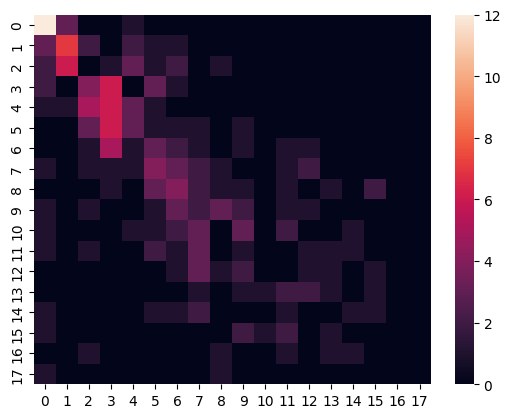

In [95]:
sns.heatmap(confusion_matrix(y_test, pred_lin_clf))

In [96]:
classification_report(y_test, pred_lin_clf, output_dict=True)

{'1': {'precision': 0.4444444444444444,
  'recall': 0.75,
  'f1-score': 0.5581395348837209,
  'support': 16.0},
 '2': {'precision': 0.4117647058823529,
  'recall': 0.4375,
  'f1-score': 0.42424242424242425,
  'support': 16.0},
 '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 16.0},
 '4': {'precision': 0.23076923076923078,
  'recall': 0.375,
  'f1-score': 0.2857142857142857,
  'support': 16.0},
 '5': {'precision': 0.2,
  'recall': 0.17647058823529413,
  'f1-score': 0.18750000000000003,
  'support': 17.0},
 '6': {'precision': 0.045454545454545456,
  'recall': 0.0625,
  'f1-score': 0.052631578947368425,
  'support': 16.0},
 '7': {'precision': 0.09090909090909091,
  'recall': 0.125,
  'f1-score': 0.10526315789473685,
  'support': 16.0},
 '8': {'precision': 0.1,
  'recall': 0.11764705882352941,
  'f1-score': 0.1081081081081081,
  'support': 17.0},
 '9': {'precision': 0.1111111111111111,
  'recall': 0.0625,
  'f1-score': 0.08,
  'support': 16.0},
 '10': {'precision': 0.142

## ARBOL

In [97]:
# Arbol

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor



### CLASIFICACION

In [98]:
tree_cla=DecisionTreeClassifier()


In [99]:
tree_cla.fit(X_train, y_train)

DecisionTreeClassifier()

In [100]:
## CROSS VALIDATION
cv_tree_clf=cross_val_score(tree_cla, X_train, y_train, cv=10)

In [101]:
cv_tree_clf.std()

0.025663069187628312

In [102]:
cv_tree_clf.mean()

0.1627049180327869

In [103]:
pred_tree_clf=tree_cla.predict(X_test)

In [104]:
dict_scoring['tree_clasiffication']=validators_reg(y_test, pred_tree_clf)


{'MAE': 2.6491228070175437, 'MSE': 12.385964912280702, 'RMSE': 3.519369959563885, 'R2': 0.3935918928591612}


In [105]:

comparador(y_test, pred_tree_clf).sample(5)


,test,pred,round,dif
2541,14,12,12,2
2562,10,11,11,-1
2441,2,8,8,-6
2489,16,16,16,0
2522,7,4,4,3


In [106]:

classification_report(y_test, pred_tree_clf, output_dict=True)

{'1': {'precision': 0.6153846153846154,
  'recall': 0.5,
  'f1-score': 0.5517241379310345,
  'support': 16.0},
 '2': {'precision': 0.07142857142857142,
  'recall': 0.0625,
  'f1-score': 0.06666666666666667,
  'support': 16.0},
 '3': {'precision': 0.17391304347826086,
  'recall': 0.25,
  'f1-score': 0.20512820512820512,
  'support': 16.0},
 '4': {'precision': 0.14285714285714285,
  'recall': 0.1875,
  'f1-score': 0.16216216216216214,
  'support': 16.0},
 '5': {'precision': 0.09523809523809523,
  'recall': 0.11764705882352941,
  'f1-score': 0.10526315789473684,
  'support': 17.0},
 '6': {'precision': 0.45454545454545453,
  'recall': 0.3125,
  'f1-score': 0.3703703703703703,
  'support': 16.0},
 '7': {'precision': 0.16666666666666666,
  'recall': 0.1875,
  'f1-score': 0.17647058823529413,
  'support': 16.0},
 '8': {'precision': 0.12,
  'recall': 0.17647058823529413,
  'f1-score': 0.14285714285714282,
  'support': 17.0},
 '9': {'precision': 0.375,
  'recall': 0.1875,
  'f1-score': 0.25,
  

### REGRESIÓN

In [107]:
tree_reg=DecisionTreeRegressor()


In [108]:
tree_reg.fit(X_train, y_train)


DecisionTreeRegressor()

In [109]:
## CROSS VALIDATION
cross_val_score(tree_reg, X_train, y_train, cv=10)

array([0.03834171, 0.1357121 , 0.33610612, 0.19427524, 0.19242049,
       0.4998265 , 0.19167714, 0.22505742, 0.2357857 , 0.32175503])

In [110]:
pred_tree_reg=tree_reg.predict(X_test)

In [111]:
dict_scoring['tree_regression']=validators_reg(y_test, np.round(pred_tree_reg).astype(int))

{'MAE': 3.06140350877193, 'MSE': 14.789473684210526, 'RMSE': 3.8457084762382245, 'R2': 0.2759177984139842}


In [112]:
comparador(y_test, np.round(pred_tree_reg).astype(int)).sample(10)

,test,pred,round,dif
2619,6,10,10,-4
2479,6,7,7,-1
2534,7,11,11,-4
2441,2,9,9,-7
2464,14,11,11,3
2452,2,5,5,-3
2655,1,1,1,0
2594,16,14,14,2
2626,13,9,9,4
2473,12,5,5,7


In [113]:
pd.crosstab(y_test, np.round(pred_tree_reg).astype(int))

col_0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
position,,,,,,,,,,,,,,,,
1,6,4,2,0,2,1,0,0,1,0,0,0,0,0,0,0
2,2,0,3,0,3,2,2,0,3,0,0,0,0,0,1,0
3,1,2,3,2,2,2,1,0,1,0,1,0,1,0,0,0
4,2,4,1,1,3,1,3,0,0,0,1,0,0,0,0,0
5,0,2,1,0,5,1,3,1,0,0,3,1,0,0,0,0
6,1,0,1,2,1,2,2,0,1,1,2,2,1,0,0,0
7,1,0,3,0,2,0,1,2,0,1,2,1,2,1,0,0
8,0,0,1,0,2,0,4,0,1,3,1,0,2,2,1,0
9,0,0,0,1,1,2,0,3,0,1,2,1,2,3,0,0


## FOREST

In [114]:
# Forest

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor


### CLASIFICACIÓN

In [115]:
forest_clf=RandomForestClassifier()

In [116]:
# probar sin los puntos de años anteriores
forest_clf.fit(X_train, y_train)

RandomForestClassifier()

In [117]:
pd.DataFrame(zip(X_train.columns, forest_clf.feature_importances_)).sort_values(by=1, ascending=False).head(5)

,0,1
130,grid,0.110842
127,race,0.086865
131,laps,0.056637
128,trackId,0.056472
138,prev_pit_total_time,0.041908


In [118]:
pred_forest_clf=forest_clf.predict(X_test)

In [119]:
dict_scoring['forst_clasiffication']=validators_reg(y_test, pred_forest_clf)


{'MAE': 2.6666666666666665, 'MSE': 13.175438596491228, 'RMSE': 3.629798699169312, 'R2': 0.3549398180414023}


In [120]:
comparador(y_test, pred_forest_clf).sample(5)


,test,pred,round,dif
2455,5,4,4,1
2575,6,3,3,3
2541,14,12,12,2
2524,9,12,12,-3
2650,6,3,3,3


In [121]:
classification_report(y_test, pred_forest_clf, output_dict=True)

{'1': {'precision': 0.48148148148148145,
  'recall': 0.8125,
  'f1-score': 0.6046511627906976,
  'support': 16.0},
 '2': {'precision': 0.2,
  'recall': 0.1875,
  'f1-score': 0.19354838709677422,
  'support': 16.0},
 '3': {'precision': 0.09523809523809523,
  'recall': 0.125,
  'f1-score': 0.1081081081081081,
  'support': 16.0},
 '4': {'precision': 0.1875,
  'recall': 0.375,
  'f1-score': 0.25,
  'support': 16.0},
 '5': {'precision': 0.11764705882352941,
  'recall': 0.11764705882352941,
  'f1-score': 0.11764705882352941,
  'support': 17.0},
 '6': {'precision': 0.041666666666666664,
  'recall': 0.0625,
  'f1-score': 0.05,
  'support': 16.0},
 '7': {'precision': 0.06666666666666667,
  'recall': 0.0625,
  'f1-score': 0.06451612903225808,
  'support': 16.0},
 '8': {'precision': 0.07142857142857142,
  'recall': 0.058823529411764705,
  'f1-score': 0.06451612903225808,
  'support': 17.0},
 '9': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 16.0},
 '10': {'precision': 0.0, 'recal

In [122]:
pd.crosstab(y_test, pred_forest_clf)

col_0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
position,,,,,,,,,,,,,,,,,
1,13,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5,3,3,1,1,2,0,0,0,1,0,0,0,0,0,0,0
3,3,2,2,3,4,1,0,0,1,0,0,0,0,0,0,0,0
4,1,2,2,6,3,2,0,0,0,0,0,0,0,0,0,0,0
5,2,2,4,5,2,2,0,0,0,0,0,0,0,0,0,0,0
6,1,2,5,3,2,1,0,0,0,1,0,1,0,0,0,0,0
7,0,0,3,3,0,5,1,3,0,0,0,0,1,0,0,0,0
8,0,0,1,4,2,3,3,1,1,0,1,1,0,0,0,0,0
9,1,0,1,1,1,1,2,2,0,2,3,2,0,0,0,0,0


### REGRESIÓN

In [123]:
forest_reg=RandomForestRegressor()

In [124]:
forest_reg.fit(X_train, y_train)

RandomForestRegressor()

In [125]:
pd.DataFrame(zip(X_train.columns, forest_reg.feature_importances_)).sort_values(by=1, ascending=False).head(5)

,0,1
130,grid,0.547375
133,prev_points,0.056480
127,race,0.049601
128,trackId,0.027356
131,laps,0.022679


In [126]:
pred_forest_reg=forest_reg.predict(X_test)

In [127]:
comparador(y_test, np.round(pred_forest_reg.astype(int))).sort_values(by='dif').sample(5)


,test,pred,round,dif
2603,7,3,3,4
2468,5,8,8,-3
2499,10,5,5,5
2508,1,1,1,0
2473,12,5,5,7


In [128]:
dict_scoring['forest_regression']=validators_reg(y_test, np.round(pred_forest_reg.astype(int))) # con los valores redondeados

{'MAE': 2.1228070175438596, 'MSE': 8.464912280701755, 'RMSE': 2.9094522303522625, 'R2': 0.5855638644540302}


In [129]:
pd.crosstab(y_test, np.round(pred_forest_reg.astype(int)))

col_0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
position,,,,,,,,,,,,,,
1,8,3,4,1,0,0,0,0,0,0,0,0,0,0
2,1,3,5,6,1,0,0,0,0,0,0,0,0,0
3,0,5,1,3,3,2,1,0,0,0,1,0,0,0
4,1,0,5,4,4,1,0,0,1,0,0,0,0,0
5,0,0,2,6,4,0,2,2,1,0,0,0,0,0
6,0,0,1,4,2,3,3,1,1,1,0,0,0,0
7,0,0,2,2,1,2,2,2,1,3,0,1,0,0
8,0,0,0,4,4,0,0,1,5,3,0,0,0,0
9,0,0,1,1,1,1,1,2,2,3,4,0,0,0


In [130]:
from sklearn.metrics import PredictionErrorDisplay

# para mostrar valor real y predicho

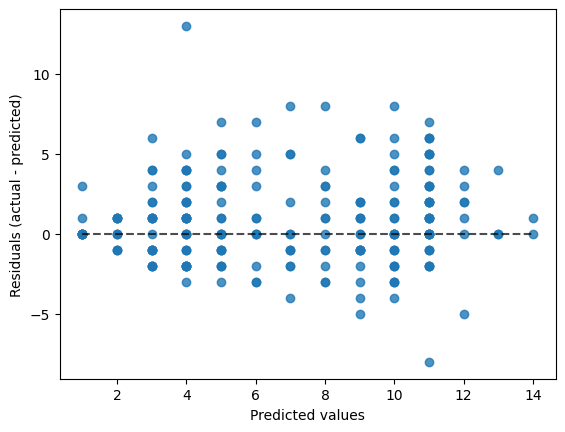

In [131]:
display = PredictionErrorDisplay(y_true=y_test, y_pred=np.round(pred_forest_reg.astype(int)))
display.plot()

## GRADIENT BOOST

In [132]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

### REGRESSOR

In [133]:
gb_reg=GradientBoostingRegressor()
gb_reg.fit(X_train, y_train)


GradientBoostingRegressor()

In [134]:
pred_gb_reg=gb_reg.predict(X_test)

In [135]:
dict_scoring['gradient_boost_regressor']=validators_reg(y_test, pred_gb_reg)

{'MAE': 2.01781871966688, 'MSE': 7.065219087981981, 'RMSE': 2.6580479845145724, 'R2': 0.6540918560627859}


In [136]:
comparador(y_test, pred_gb_reg)

,test,pred,round,dif
2440,1,2.605640,3,-2
2441,2,3.180809,3,-1
2442,3,6.093517,6,-3
2443,4,4.830501,5,-1
2444,5,6.037392,6,-1
2445,6,8.009125,8,-2
2446,7,5.985916,6,1
2447,8,9.942866,10,-2
2448,9,11.418753,11,-2
2449,10,11.878368,12,-2


In [137]:
pd.crosstab(y_test, np.round(pred_gb_reg).astype(int))

col_0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
position,,,,,,,,,,,,,,
1,1,9,4,2,0,0,0,0,0,0,0,0,0,0
2,0,1,7,5,3,0,0,0,0,0,0,0,0,0
3,0,0,6,2,1,5,1,0,0,1,0,0,0,0
4,0,1,2,4,5,3,0,1,0,0,0,0,0,0
5,0,0,0,7,3,2,3,2,0,0,0,0,0,0
6,0,0,0,4,3,3,3,2,1,0,0,0,0,0
7,0,0,0,1,2,3,3,4,2,0,1,0,0,0
8,0,0,1,1,2,3,0,5,2,2,1,0,0,0
9,0,0,0,1,0,2,1,4,3,0,3,2,0,0


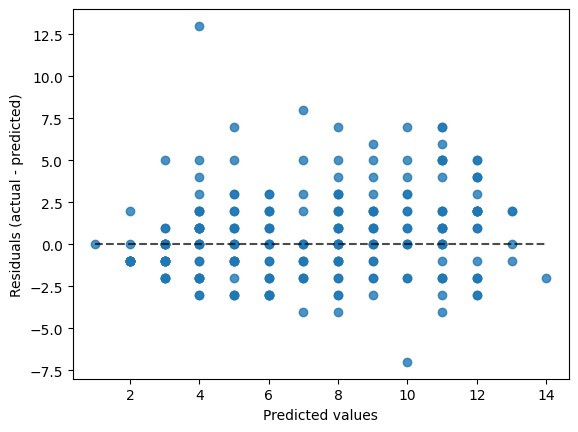

In [138]:
grid_reg_display = PredictionErrorDisplay(y_true=y_test, y_pred=np.round(pred_gb_reg).astype(int))
grid_reg_display.plot()

### CLASSIFIER

In [139]:
gb_clf=GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)


GradientBoostingClassifier()

In [140]:
pred_gb_clf=gb_clf.predict(X_test)

In [141]:
dict_scoring['gradient_boost_classifier']=validators_reg(y_test, pred_gb_clf)

{'MAE': 2.7982456140350878, 'MSE': 14.25438596491228, 'RMSE': 3.775498108185499, 'R2': 0.30211531579046524}


In [142]:
comparador(y_test,pred_gb_clf).sample(10)

,test,pred,round,dif
2620,7,15,15,-8
2472,11,1,1,10
2656,2,5,5,-3
2534,7,13,13,-6
2606,10,8,8,2
2522,7,8,8,-1
2517,2,2,2,0
2483,10,6,6,4
2667,13,13,13,0
2593,15,15,15,0


In [143]:
pd.crosstab(y_test, np.round(pred_gb_clf).astype(int))

col_0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
position,,,,,,,,,,,,,,,,,
1,12,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,6,1,0,1,0,4,0,0,1,0,0,0,0,0,0,0
3,2,5,0,2,1,1,2,1,0,1,0,0,0,1,0,0,0
4,0,3,5,3,2,2,1,0,0,0,0,0,0,0,0,0,0
5,2,3,2,3,3,3,0,0,0,1,0,0,0,0,0,0,0
6,0,0,2,6,0,1,0,0,2,2,1,0,0,1,0,1,0
7,0,0,1,3,0,2,4,2,1,0,0,0,1,0,1,1,0
8,0,1,1,2,1,3,2,0,4,1,0,1,0,0,0,1,0
9,0,0,0,1,0,4,0,1,2,1,2,4,0,1,0,0,0


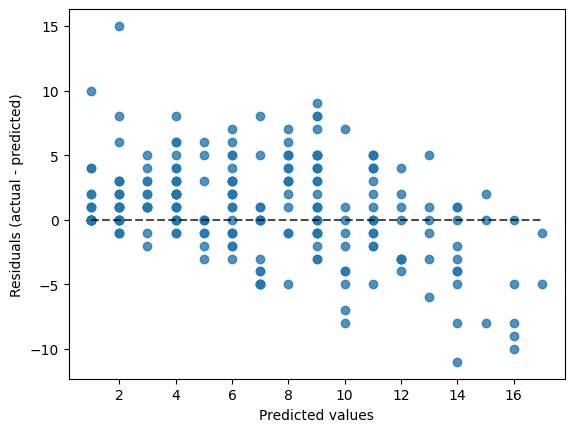

In [144]:
grid_clf_display = PredictionErrorDisplay(y_true=y_test, y_pred=np.round(pred_gb_clf).astype(int))
grid_clf_display.plot()

## SVM

In [145]:
# Ensamblador

from sklearn.svm import SVC, SVR , LinearSVC, LinearSVR

### LinearSVC

In [146]:
l_svc=LinearSVC()
l_svc.fit(X_train, y_train)

LinearSVC()

In [147]:
pred_l_svc=l_svc.predict(X_test)

In [148]:
comparador(y_test, np.round(pred_l_svc.astype(int))).sort_values(by='dif').sample(5)

,test,pred,round,dif
2633,4,4,4,0
2516,1,1,1,0
2499,10,15,15,-5
2567,15,16,16,-1
2514,7,7,7,0


In [149]:
dict_scoring['linear_svc']=validators_reg(y_test, np.round(pred_l_svc.astype(int)))

{'MAE': 3.1008771929824563, 'MSE': 18.67105263157895, 'RMSE': 4.3210013459357945, 'R2': 0.08587843056000322}


In [150]:
pd.crosstab(y_test, np.round(pred_l_svc.astype(int)))

col_0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
position,,,,,,,,,,,,,,,,,,
1,13,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5,6,0,0,0,0,4,0,0,1,0,0,0,0,0,0,0,0
3,5,5,0,3,0,0,3,0,0,0,0,0,0,0,0,0,0,0
4,3,2,3,6,0,0,2,0,0,0,0,0,0,0,0,0,0,0
5,3,2,5,5,1,1,0,0,0,0,0,0,0,0,0,0,0,0
6,1,2,3,4,1,0,1,1,0,1,0,0,0,0,2,0,0,0
7,0,1,1,6,0,1,3,1,0,0,0,0,2,0,0,1,0,0
8,1,0,2,2,0,2,5,2,0,0,0,1,2,0,0,0,0,0
9,0,1,0,1,1,2,2,0,1,4,0,1,0,0,0,3,0,0


### LinearSVR

In [151]:
l_svr=LinearSVR()
l_svr.fit(X_train, y_train)

LinearSVR()

In [152]:
pred_l_svr=l_svr.predict(X_test)

In [153]:
comparador(y_test, np.round(pred_l_svr.astype(int))).sort_values(by='dif').sample(5)

,test,pred,round,dif
2466,16,10,10,6
2472,11,3,3,8
2632,3,3,3,0
2556,4,5,5,-1
2523,8,6,6,2


In [154]:
dict_scoring['linear_svr']=validators_reg(y_test, np.round(pred_l_svr.astype(int)))

{'MAE': 2.5219298245614037, 'MSE': 12.662280701754385, 'RMSE': 3.558409855785922, 'R2': 0.38006366667294555}


In [155]:
pd.crosstab(y_test, np.round(pred_l_svr.astype(int)))

col_0,-1,0,1,2,3,4,5,6,7,8,9,10,11,12
position,,,,,,,,,,,,,,
1,0,6,8,0,1,0,1,0,0,0,0,0,0,0
2,0,0,4,2,4,4,1,1,0,0,0,0,0,0
3,0,0,3,1,2,4,4,1,0,0,0,1,0,0
4,0,1,1,1,5,3,4,1,0,0,0,0,0,0
5,0,1,0,2,2,3,6,2,1,0,0,0,0,0
6,0,0,0,1,3,3,2,3,1,2,1,0,0,0
7,0,0,0,0,0,2,4,5,2,1,1,1,0,0
8,0,0,0,1,0,1,1,7,2,1,4,0,0,0
9,0,0,0,0,1,0,0,3,1,3,3,3,2,0


### SVC

In [156]:
svc=SVC()
svc.fit(X_train, y_train)
pred_svc=svc.predict(X_test)


In [157]:
comparador(y_test, np.round(pred_svc.astype(int))).sort_values(by='dif').sample(5)


,test,pred,round,dif
2463,13,8,8,5
2638,9,6,6,3
2632,3,3,3,0
2556,4,4,4,0
2634,5,5,5,0


In [158]:
dict_scoring['svc']=validators_reg(y_test, np.round(pred_svc.astype(int)))


{'MAE': 2.9210526315789473, 'MSE': 17.087719298245613, 'RMSE': 4.133729466020438, 'R2': 0.16339731394450852}


In [159]:
pd.crosstab(y_test, np.round(pred_svc.astype(int)))

col_0,1,2,3,4,5,6,7,8,10,11,12
position,,,,,,,,,,,
1,12,2,1,1,0,0,0,0,0,0,0
2,2,3,6,4,0,1,0,0,0,0,0
3,1,2,5,0,5,3,0,0,0,0,0
4,2,1,4,4,2,2,1,0,0,0,0
5,1,0,5,4,3,4,0,0,0,0,0
6,0,0,3,2,6,5,0,0,0,0,0
7,0,0,1,4,2,3,2,4,0,0,0
8,0,1,1,0,2,8,1,4,0,0,0
9,0,0,1,0,2,4,2,4,2,1,0


### SVR

In [160]:
svr=SVR(C=0.5, kernel="poly", degree=3)
svr.fit(X_train, y_train)


SVR(C=0.5, kernel='poly')

In [161]:
pred_svr=svr.predict(X_test)


In [162]:
comparador(y_test, np.round(pred_svr.astype(int))).sort_values(by='dif').sample(5)


,test,pred,round,dif
2458,8,6,6,2
2603,7,4,4,3
2608,12,9,9,3
2553,1,0,0,1
2543,2,2,2,0


In [163]:
dict_scoring['svr']=validators_reg(y_test, np.round(pred_svr.astype(int)))


{'MAE': 2.587719298245614, 'MSE': 13.578947368421053, 'RMSE': 3.684962329308273, 'R2': 0.3351843131345478}


In [164]:
pd.crosstab(y_test, np.round(pred_svr.astype(int)))

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13
position,,,,,,,,,,,,,,
1,5,7,3,0,1,0,0,0,0,0,0,0,0,0
2,0,3,4,4,2,3,0,0,0,0,0,0,0,0
3,0,2,2,2,5,3,1,0,1,0,0,0,0,0
4,1,0,1,5,3,4,1,1,0,0,0,0,0,0
5,1,0,1,1,6,5,1,2,0,0,0,0,0,0
6,0,0,0,1,4,7,3,0,1,0,0,0,0,0
7,0,0,0,0,3,3,4,3,2,1,0,0,0,0
8,0,0,1,0,2,2,4,3,2,2,1,0,0,0
9,0,0,0,1,0,2,3,3,2,1,2,1,1,0


## XGBOOST

In [165]:
import xgboost

In [166]:
xgb=xgboost.XGBRFRegressor(device='cuda')
xgb.fit(X_train,y_train)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None, device='cuda',
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=None, reg_alpha=None, ...)

In [167]:
pred_xgb=xgb.predict(X_test)

In [168]:
comparador(y_test, np.round(pred_xgb.astype(int))).sort_values(by='dif').sample(5)


,test,pred,round,dif
2633,4,3,3,1
2470,9,11,11,-2
2569,17,11,11,6
2547,6,3,3,3
2570,1,2,2,-1


In [169]:
dict_scoring['xgboost']=validators_reg(y_test, np.round(pred_xgb.astype(int)))


{'MAE': 2.258771929824561, 'MSE': 9.118421052631579, 'RMSE': 3.019672341932412, 'R2': 0.5535685358548853}


In [170]:
pd.crosstab(y_test, np.round(pred_xgb.astype(int)))

col_0,1,2,3,4,5,6,7,8,9,10,11
position,,,,,,,,,,,
1,8,5,3,0,0,0,0,0,0,0,0
2,1,2,7,5,1,0,0,0,0,0,0
3,0,6,2,0,4,1,2,0,1,0,0
4,1,0,7,3,3,1,0,0,1,0,0
5,0,0,3,7,2,1,1,3,0,0,0
6,0,0,2,2,3,3,3,1,2,0,0
7,0,0,1,3,1,3,0,3,3,1,1
8,0,0,2,2,4,0,0,2,4,3,0
9,0,0,1,1,1,0,1,3,4,2,3


In [171]:
import lazypredict

In [172]:
from lazypredict.Supervised import LazyClassifier,LazyRegressor

In [173]:
lazy_clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)

modelos,predicciones = lazy_clf.fit(X_train, X_test, y_train, y_test)

 90%|████████▉ | 26/29 [02:27<00:02,  1.36it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1434
[LightGBM] [Info] Number of data points in the train set: 2440, number of used features: 87
[LightGBM] [Info] Start training from score -2.340168
[LightGBM] [Info] Start training from score -2.340168
[LightGBM] [Info] Start training from score -2.344432
[LightGBM] [Info] Start training from score -2.361674
[LightGBM] [Info] Start training from score -2.397076
[LightGBM] [Info] Start training from score -2.447895
[LightGBM] [Info] Start training from score -2.558006
[LightGBM] [Info] Start training from score -2.669855
[LightGBM] [Info] Start training from score -2.789118
[LightGBM] [Info] Start training from score -2.932219
[LightGBM] [Info] Start training from score -3.054821
[LightGBM] [Info] Start training from score -3.245876


100%|██████████| 29/29 [02:28<00:00,  5.14s/it]


In [174]:

print(modelos)

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
LGBMClassifier                     0.21               0.18    None      0.18   
NearestCentroid                    0.18               0.16    None      0.16   
BernoulliNB                        0.16               0.15    None      0.13   
DecisionTreeClassifier             0.17               0.15    None      0.17   
LinearDiscriminantAnalysis         0.18               0.14    None      0.15   
RandomForestClassifier             0.16               0.13    None      0.14   
LogisticRegression                 0.15               0.13    None      0.13   
RidgeClassifier                    0.16               0.13    None      0.13   
RidgeClassifierCV                  0.16               0.13    None      0.12   
ExtraTreeClassifier                0.13               0.11    None      0.13   
GaussianNB                         0.11 

In [175]:
lazy_reg = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)

mod_reg,pred_reg = lazy_reg.fit(X_train, X_test, y_train, y_test)


  0%|          | 0/42 [00:00<?, ?it/s]

100%|██████████| 42/42 [00:23<00:00,  1.80it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1434
[LightGBM] [Info] Number of data points in the train set: 2440, number of used features: 87
[LightGBM] [Info] Start training from score 6.418852


In [176]:
print(mod_reg)

                                            Adjusted R-Squared  \
Model                                                            
GradientBoostingRegressor                                 0.09   
ExtraTreesRegressor                                       0.01   
RandomForestRegressor                                    -0.02   
XGBRegressor                                             -0.13   
HistGradientBoostingRegressor                            -0.13   
LGBMRegressor                                            -0.16   
BaggingRegressor                                         -0.19   
PoissonRegressor                                         -0.27   
RidgeCV                                                  -0.28   
BayesianRidge                                            -0.28   
Ridge                                                    -0.28   
LassoLarsIC                                              -0.30   
ElasticNetCV                                             -0.31   
AdaBoostRe

## HIPERPARÁMETROS

In [177]:
dict_scoring.values()

dict_values([{'MAE': 2.230905633223684, 'MSE': 9.726165236088267, 'RMSE': 3.118680047085348, 'R2': 0.5238138092327861}, {'MAE': 2.7017543859649122, 'MSE': 14.87719298245614, 'RMSE': 3.857096444536504, 'R2': 0.2716231234342332}, {'MAE': 2.6491228070175437, 'MSE': 12.385964912280702, 'RMSE': 3.519369959563885, 'R2': 0.3935918928591612}, {'MAE': 3.06140350877193, 'MSE': 14.789473684210526, 'RMSE': 3.8457084762382245, 'R2': 0.2759177984139842}, {'MAE': 2.6666666666666665, 'MSE': 13.175438596491228, 'RMSE': 3.629798699169312, 'R2': 0.3549398180414023}, {'MAE': 2.1228070175438596, 'MSE': 8.464912280701755, 'RMSE': 2.9094522303522625, 'R2': 0.5855638644540302}, {'MAE': 2.01781871966688, 'MSE': 7.065219087981981, 'RMSE': 2.6580479845145724, 'R2': 0.6540918560627859}, {'MAE': 2.7982456140350878, 'MSE': 14.25438596491228, 'RMSE': 3.775498108185499, 'R2': 0.30211531579046524}, {'MAE': 3.1008771929824563, 'MSE': 18.67105263157895, 'RMSE': 4.3210013459357945, 'R2': 0.08587843056000322}, {'MAE': 2.5

In [229]:
for k,v in dict_scoring.items():
    print(k,':',v['MAE'])

linear regression : 2.230905633223684
logistic regression : 2.7017543859649122
tree_clasiffication : 2.6491228070175437
tree_regression : 3.06140350877193
forst_clasiffication : 2.6666666666666665
forest_regression : 2.1228070175438596
gradient_boost_regressor : 2.01781871966688
gradient_boost_classifier : 2.7982456140350878
linear_svc : 3.1008771929824563
linear_svr : 2.5219298245614037
svc : 2.9210526315789473
svr : 2.587719298245614
xgboost : 2.258771929824561


In [179]:
# GradientBoostRegressor es el que más se acerca a las predicciones

# hacer cross_val_score

cvs_gb_reg=cross_val_score(estimator=gb_reg,
                X=X_train,
                y=y_train,
                scoring='neg_mean_absolute_percentage_error',
                cv=5
                )

In [180]:
cvs_gb_reg*-1

array([0.57269644, 0.46252077, 0.42892132, 0.43346784, 0.47869629])

In [181]:
# GridSearchCV

gb_reg.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [182]:
parametros={
    'n_estimators': np.arange(4,21,2),
    'criterion': ['squared_error', 'friedman_mse'],
    'max_features': ["auto", "sqrt", "log2"],
    'max_depth': np.arange(2,15,2),
}

In [183]:
grid=GridSearchCV(estimator=gb_reg,
             param_grid=parametros,
             scoring='r2',
             cv=8,
             refit=True
             )

In [184]:
grid.fit(X_train, y_train)

GridSearchCV(cv=8, estimator=GradientBoostingRegressor(),
             param_grid={'criterion': ['squared_error', 'friedman_mse'],
                         'max_depth': array([ 2,  4,  6,  8, 10, 12, 14]),
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': array([ 4,  6,  8, 10, 12, 14, 16, 18, 20])},
             scoring='r2')

In [185]:
grid.cv_results_

{'mean_fit_time': array([1.37543678e-03, 1.53687596e-03, 2.15864182e-03, 1.72799826e-03,
        1.34256482e-03, 1.30227208e-03, 1.61769986e-03, 1.68094039e-03,
        1.74033642e-03, 8.13978910e-03, 1.14693940e-02, 1.22098625e-02,
        9.76741314e-03, 1.36685073e-02, 1.56218410e-02, 1.47704184e-02,
        1.95252895e-02, 1.95318758e-02, 5.85335493e-03, 5.32358885e-03,
        9.76324081e-03, 1.17167830e-02, 1.17160380e-02, 9.76902246e-03,
        1.56130195e-02, 1.56263411e-02, 1.75735056e-02, 0.00000000e+00,
        1.95226073e-03, 4.42266464e-04, 1.95276737e-03, 0.00000000e+00,
        1.95223093e-03, 1.95255876e-03, 1.95270777e-03, 1.94856524e-03,
        1.17161870e-02, 1.36642158e-02, 1.56310797e-02, 1.75776780e-02,
        1.75746381e-02, 2.34315991e-02, 2.73334086e-02, 2.53848433e-02,
        2.92993188e-02, 7.80865550e-03, 1.17204487e-02, 1.56169236e-02,
        1.56224370e-02, 1.75696611e-02, 1.95264220e-02, 1.75737739e-02,
        2.10334063e-02, 2.73356736e-02, 1.95673

In [186]:
grid.scorer_

make_scorer(r2_score)

In [187]:
grid.refit_time_

0.11643552780151367

In [188]:
grid.best_params_
# {'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 20}

{'criterion': 'squared_error',
 'max_depth': 12,
 'max_features': 'sqrt',
 'n_estimators': 20}

In [189]:
print(grid.best_estimator_)  # mejor estimador
# respuesta GradientBoostingRegressor(criterion='squared_error', max_depth=10,max_features='sqrt', n_estimators=20)


GradientBoostingRegressor(criterion='squared_error', max_depth=12,
                          max_features='sqrt', n_estimators=20)


In [190]:
print(grid.best_score_)

0.5497770713898632


In [191]:
# mejores atributos de cada uno
pd.DataFrame(grid.cv_results_).sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
152,0.11,0.01,0.00,0.01,squared_error,12,sqrt,20,"{'criterion': 'squared_error', 'max_depth': 12...",0.45,0.55,0.57,0.59,0.61,0.58,0.50,0.54,0.55,0.05,1
367,0.11,0.00,0.00,0.00,friedman_mse,14,sqrt,18,"{'criterion': 'friedman_mse', 'max_depth': 14,...",0.45,0.52,0.57,0.59,0.63,0.58,0.48,0.50,0.54,0.06,2
368,0.12,0.00,0.00,0.00,friedman_mse,14,sqrt,20,"{'criterion': 'friedman_mse', 'max_depth': 14,...",0.45,0.56,0.56,0.57,0.62,0.57,0.48,0.52,0.54,0.05,3
179,0.12,0.01,0.00,0.01,squared_error,14,sqrt,20,"{'criterion': 'squared_error', 'max_depth': 14...",0.45,0.52,0.56,0.59,0.62,0.57,0.50,0.52,0.54,0.05,4
125,0.08,0.01,0.00,0.01,squared_error,10,sqrt,20,"{'criterion': 'squared_error', 'max_depth': 10...",0.45,0.52,0.55,0.59,0.63,0.59,0.48,0.50,0.54,0.06,5
341,0.10,0.01,0.00,0.00,friedman_mse,12,sqrt,20,"{'criterion': 'friedman_mse', 'max_depth': 12,...",0.43,0.52,0.55,0.59,0.62,0.56,0.50,0.53,0.54,0.05,6
314,0.08,0.01,0.00,0.00,friedman_mse,10,sqrt,20,"{'criterion': 'friedman_mse', 'max_depth': 10,...",0.45,0.54,0.53,0.59,0.61,0.57,0.51,0.48,0.53,0.05,7
124,0.07,0.01,0.00,0.01,squared_error,10,sqrt,18,"{'criterion': 'squared_error', 'max_depth': 10...",0.45,0.54,0.54,0.57,0.61,0.57,0.50,0.50,0.53,0.05,8
188,0.10,0.02,0.00,0.01,squared_error,14,log2,20,"{'criterion': 'squared_error', 'max_depth': 14...",0.45,0.53,0.53,0.60,0.61,0.58,0.49,0.47,0.53,0.06,9
177,0.11,0.01,0.00,0.01,squared_error,14,sqrt,16,"{'criterion': 'squared_error', 'max_depth': 14...",0.46,0.53,0.54,0.57,0.62,0.56,0.48,0.48,0.53,0.05,10


In [192]:
# si ha hecho refit, probar predicción
pred_refit_gb_reg=grid.predict(X_test)

In [193]:
pred_refit_gb_reg.shape

(228,)

In [194]:
validators_reg(y_test, pred_refit_gb_reg)

{'MAE': 2.399940965408304, 'MSE': 9.869513031821905, 'RMSE': 3.1415781116855754, 'R2': 0.5167956022469534}


{'MAE': 2.399940965408304,
 'MSE': 9.869513031821905,
 'RMSE': 3.1415781116855754,
 'R2': 0.5167956022469534}

In [195]:
comparador(y_test, pred_refit_gb_reg).sample(10)

,test,pred,round,dif
2576,7,4.77,5,2
2594,16,9.90,10,6
2650,6,4.49,4,2
2584,6,7.32,7,-1
2442,3,6.82,7,-4
2498,9,7.75,8,1
2486,13,12.05,12,1
2625,12,7.29,7,5
2532,5,6.17,6,-1
2471,10,9.36,9,1


In [196]:
pd.crosstab(y_test, np.round(pred_refit_gb_reg).astype(int))

col_0,2,3,4,5,6,7,8,9,10,11,12,13
position,,,,,,,,,,,,
1,5,7,3,1,0,0,0,0,0,0,0,0
2,1,3,3,5,3,0,1,0,0,0,0,0
3,0,1,5,3,1,4,1,0,1,0,0,0
4,0,3,3,4,2,3,1,0,0,0,0,0
5,0,1,4,5,3,3,1,0,0,0,0,0
6,0,0,3,1,5,4,2,0,1,0,0,0
7,0,0,0,3,6,2,2,1,0,2,0,0
8,0,0,1,2,4,3,1,4,2,0,0,0
9,0,0,1,0,1,3,3,5,1,2,0,0


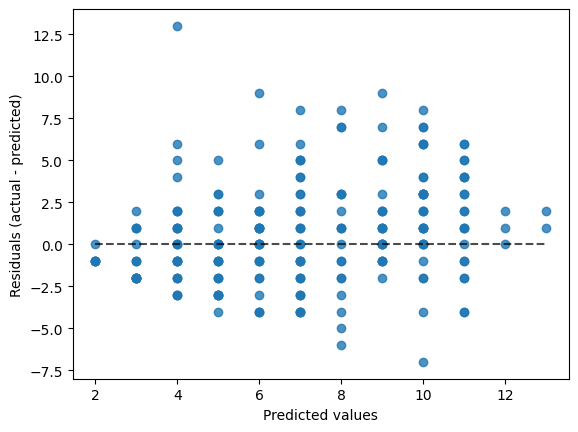

In [197]:
refit_grid_reg_display = PredictionErrorDisplay(y_true=y_test, y_pred=np.round(pred_refit_gb_reg).astype(int))
refit_grid_reg_display.plot()

In [198]:
# joblib
import joblib

# guardar:  
joblib.dump(grid, '../modelos/grid_gb_reg.pkl', compress=1)

# cargar:   joblib.load('./modelos/grid_forest_reg.pkl')


['../modelos/grid_gb_reg.pkl']

In [199]:
df_1.head(10)

,track_70th Anniversary GP,track_Abu Dhabi GP,track_Australian GP,track_Austrian GP,track_Azerbaijan GP,track_Bahrain GP,track_Belgian GP,track_Brazilian GP,track_British GP,track_Canadian GP,track_Chinese GP,track_Dutch GP,track_Eifel GP,track_Emilia Romagna GP,track_European GP,track_French GP,track_German GP,track_Hungarian GP,track_Indian GP,track_Italian GP,track_Japanese GP,track_Korean GP,track_Malaysian GP,track_Mexican GP,track_Mexico City GP,track_Miami GP,track_Monaco GP,track_Portuguese GP,track_Qatar GP,track_Russian GP,track_Sakhir GP,track_Saudi Arabian GP,track_Singapore GP,track_Spanish GP,track_Styrian GP,track_São Paulo GP,track_Turkish GP,track_Tuscan GP,track_United States GP,driver_aitken,driver_albon,driver_alguersuari,driver_alonso,driver_ambrosio,driver_barrichello,driver_bottas,driver_brendon_hartley,driver_bruno_senna,driver_buemi,driver_button,driver_chilton,driver_de_vries,driver_ericsson,driver_garde,driver_gasly,driver_giovinazzi,driver_glock,driver_grosjean,driver_gutierrez,driver_hamilton,driver_heidfeld,driver_hulkenberg,driver_jolyon_palmer,driver_jules_bianchi,driver_kevin_magnussen,driver_kobayashi,driver_kovalainen,driver_kubica,driver_kvyat,driver_latifi,driver_lawson,driver_leclerc,driver_maldonado,driver_massa,driver_max_verstappen,driver_mazepin,driver_michael_schumacher,driver_mick_schumacher,driver_nasr,driver_norris,driver_ocon,driver_perez,driver_petrov,driver_piastri,driver_pic,driver_pietro_fittipaldi,driver_raikkonen,driver_resta,driver_ricciardo,driver_rosa,driver_rosberg,driver_rossi,driver_russell,driver_sainz,driver_sargeant,driver_sirotkin,driver_stroll,driver_sutil,driver_trulli,driver_tsunoda,driver_vandoorne,driver_vergne,driver_vettel,driver_webber,driver_wehrlein,driver_zhou,team_alfa,team_alphatauri,team_alpine,team_aston_martin,team_caterham,team_ferrari,team_force_india,team_haas,team_hrt,team_lotus_f1,team_lotus_racing,team_manor,team_marussia,team_mclaren,team_mercedes,team_racing_point,team_red_bull,team_renault,team_sauber,team_toro_rosso,team_williams,race,trackId,year,grid,laps,prev_position,prev_points,prev_pit_mean_drv,prev_pit_mean_race,prev_total_stops,prev_total_race_time,prev_pit_total_time,prev_fast_lap,year_orig
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.67,0.08,-0.00,-0.92,-0.31,-1.11,-1.00,-1.24,-1.24,-1.14,-1.23,-1.23,-1.22,2011
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,-1.67,0.08,-0.00,-1.67,-0.31,-1.11,-1.00,-1.24,-1.24,-1.14,-1.23,-1.23,-1.22,2011
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00

In [225]:
def media_team_driver(df, tm=""):
    # media de posiciones finales por equipo y conductor
    if tm=="": # devuelve todo
        return df.groupby(['team', 'driver']).agg({'position':'mean', 'race':'count'}).sort_values(['team', 'position'])
    else: # si se le pasa un equipo(o lista de equipos), devuelve solo esos
        tm=list(set(tm))
        return df[df.team.isin(tm)].groupby(['team', 'driver']).agg({'position':'mean', 'race':'count'}).sort_values(['team', 'position'])

In [226]:
#t=['ferrari']
t=['ferrari','mercedes']

In [227]:
media_team_driver(f1_original,t)

position  race
team     driver                            
ferrari  vettel                  3.81    97
         alonso                  3.99    68
         leclerc                 4.44    75
         raikkonen               4.72    75
         sainz                   5.23    47
         massa                   6.89    46
mercedes hamilton                2.71   196
         bottas                  3.33    86
         rosberg                 4.22    94
         russell                 5.06    34
         michael_schumacher      7.65    20

In [228]:
dict_scoring

{'linear regression': {'MAE': 2.230905633223684,
  'MSE': 9.726165236088267,
  'RMSE': 3.118680047085348,
  'R2': 0.5238138092327861},
 'logistic regression': {'MAE': 2.7017543859649122,
  'MSE': 14.87719298245614,
  'RMSE': 3.857096444536504,
  'R2': 0.2716231234342332},
 'tree_clasiffication': {'MAE': 2.6491228070175437,
  'MSE': 12.385964912280702,
  'RMSE': 3.519369959563885,
  'R2': 0.3935918928591612},
 'tree_regression': {'MAE': 3.06140350877193,
  'MSE': 14.789473684210526,
  'RMSE': 3.8457084762382245,
  'R2': 0.2759177984139842},
 'forst_clasiffication': {'MAE': 2.6666666666666665,
  'MSE': 13.175438596491228,
  'RMSE': 3.629798699169312,
  'R2': 0.3549398180414023},
 'forest_regression': {'MAE': 2.1228070175438596,
  'MSE': 8.464912280701755,
  'RMSE': 2.9094522303522625,
  'R2': 0.5855638644540302},
 'gradient_boost_regressor': {'MAE': 2.01781871966688,
  'MSE': 7.065219087981981,
  'RMSE': 2.6580479845145724,
  'R2': 0.6540918560627859},
 'gradient_boost_classifier': {'MAE